Modelo LSTM para prever o parâmetro pH 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import math
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize']= 18
plt.rcParams['ytick.labelsize']= 18
plt.rcParams.update({'font.size':18})

In [3]:
str_files = ''

#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'ph.csv',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

In [4]:
#df.head()

In [5]:
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']
#z.info()

In [6]:
z = z.dropna(axis=1,how='any')
#for field in z.columns:
    #print(field,'NaN',z[field].isnull().sum())
#print(len(z))

In [7]:
trainingd = z.resample('3M').mean()
trainingd
data = trainingd.iloc[:,1:2].values

train = trainingd.iloc[0:133,1:2].values  
test = trainingd.iloc[133:,1:2].values   
print('treino:',len(train))
print('teste:',len(test))
len(test)

treino: 133
teste: 33


33

In [8]:
sc = MinMaxScaler()
train_normalizado = sc.fit_transform(train)

In [9]:
timestamp = 8
previsores = []
ph_real    = []
for i in range(timestamp, len(train)):
    previsores.append(train_normalizado[i-timestamp:i, 0])
    ph_real.append(train_normalizado[i, 0])
previsores, ph_real = np.array(previsores), np.array(ph_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))
previsores.shape

(125, 8, 1)

In [10]:
print("Rede Neural LSTM com 10 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 10, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 10, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 10, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, ph_real, epochs = 100, batch_size = 32)


Rede Neural LSTM com 10 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 15s 121ms/sample - loss: 0.2688
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.2306
Epoch 3/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1914
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1563
Epoch 5/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1217
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0889
Epoch 7/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0530
Epoch 8/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0422
Epoch 9/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0401
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0446
Epoch 11/100
125/125 [==============================] - 

125/125 [==============================] - 0s 3ms/sample - loss: 0.0296
Epoch 97/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0310
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0318
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0308


In [11]:
ph_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

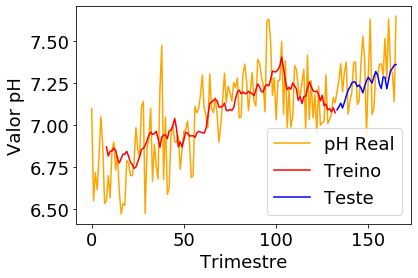

In [12]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='pH Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor pH')
plt.legend(loc='best')
plt.show()

In [13]:
print('Previsão (média):',round(previsoes.mean(),2))
print('pH Real (média):', round(ph_real_teste.mean(),2))
print('Diferença (média):', round(ph_real_teste.mean() - previsoes.mean(),2))

Previsão (média): 7.24
pH Real (média): 7.3
Diferença (média): 0.06


In [14]:
train_score10 = model.evaluate(previsores, ph_real, verbose=0)
ph10_mse  = train_score10
ph10_rmse = math.sqrt(train_score10)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score10, math.sqrt(train_score10)))
#test_score10 = mdl.evaluate(X_test, y_test, verbose=0)
#print('Pontuação de teste: {:.2f} MSE ({:.2f} RMSE)'.format(test_score10, math.sqrt(test_score10)))

Pontuação de Treino: 0.02 MSE (0.15 RMSE)


In [15]:
print("Rede Neural LSTM com 25 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 25, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 25, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 25, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, ph_real, epochs = 100, batch_size = 32)

Rede Neural LSTM com 25 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 162s 1s/sample - loss: 0.2516
Epoch 2/100
125/125 [==============================] - 1s 5ms/sample - loss: 0.1760
Epoch 3/100
125/125 [==============================] - 1s 5ms/sample - loss: 0.1028
Epoch 4/100
125/125 [==============================] - 1s 5ms/sample - loss: 0.0461
Epoch 5/100
125/125 [==============================] - 1s 5ms/sample - loss: 0.0352
Epoch 6/100
125/125 [==============================] - 0s 4ms/sample - loss: 0.0487
Epoch 7/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0356
Epoch 8/100
125/125 [==============================] - 0s 1ms/sample - loss: 0.0288
Epoch 9/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0328
Epoch 10/100
125/125 [==============================] - 0s 1ms/sample - loss: 0.0338
Epoch 11/100
125/125 [==============================] - 0s

125/125 [==============================] - 0s 4ms/sample - loss: 0.0267
Epoch 97/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0243
Epoch 98/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0245
Epoch 99/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0259
Epoch 100/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0235


In [16]:
ph_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

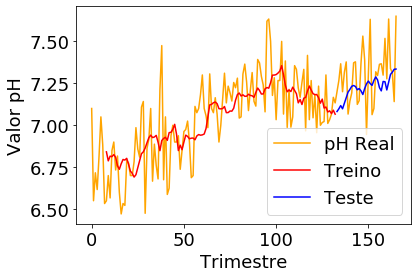

Previsão (média): 7.22
pH Real (média): 7.3
Diferença (média): 0.08
Pontuação de Treino: 0.02 MSE (0.15 RMSE)


In [17]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='pH Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor pH')
plt.legend(loc='best')
plt.show()

print('Previsão (média):',round(previsoes.mean(),2))
print('pH Real (média):', round(ph_real_teste.mean(),2))
print('Diferença (média):', round(ph_real_teste.mean() - previsoes.mean(),2))

train_score25 = model.evaluate(previsores, ph_real, verbose=0)
ph25_mse  = train_score25
ph25_rmse = math.sqrt(train_score25)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score25, math.sqrt(train_score25)))


In [18]:
print("Rede Neural LSTM com 50 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 50, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, ph_real, epochs = 100, batch_size = 32)

Rede Neural LSTM com 50 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 14s 109ms/sample - loss: 0.2730
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1577
Epoch 3/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0550
Epoch 4/100
125/125 [==============================] - 0s 4ms/sample - loss: 0.0475
Epoch 5/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0377
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0299
Epoch 7/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0350
Epoch 8/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0310
Epoch 9/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0280
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0306
Epoch 11/100
125/125 [==============================] - 

125/125 [==============================] - 0s 3ms/sample - loss: 0.0262
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0236
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0232
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0233


In [19]:
ph_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

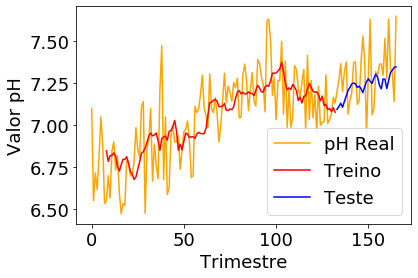

Previsão (média): 7.24
pH Real (média): 7.3
Diferença (média): 0.07
Pontuação de Treino: 0.02 MSE (0.15 RMSE)


In [20]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='pH Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor pH')
plt.legend(loc='best')
plt.show()

print('Previsão (média):',round(previsoes.mean(),2))
print('pH Real (média):', round(ph_real_teste.mean(),2))
print('Diferença (média):', round(ph_real_teste.mean() - previsoes.mean(),2))

train_score50 = model.evaluate(previsores, ph_real, verbose=0)
ph50_mse  = train_score50
ph50_rmse = math.sqrt(train_score50)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score50, math.sqrt(train_score50)))
    


In [21]:
ph_media_mse = (ph10_mse+ph25_mse+ph50_mse)/3
ph_media_rmse = (ph10_rmse+ph25_rmse+ph50_rmse)/3

print('ph_media_mse:', round(ph_media_mse,3))
print('ph_media_rmse:', round(ph_media_rmse,3))

ph_media_mse: 0.022
ph_media_rmse: 0.15
